In [1]:
import os
import json
import pickle
import io
import pandas as pd
from dataclasses import asdict
from backdoors import data, patterns, poison, utils
from backdoors.data import load_cifar10, Data
import numpy as np
import matplotlib.pyplot as plt
import einops
import jax
from jax import numpy as jnp
from flax.training import train_state
import optax
import chex
import flax
from flax import linen as nn
from typing import Tuple
import matplotlib.pyplot as plt
import sympy
from jax import random
from collections import namedtuple
from time import time

import orbax.checkpoint
import os
from pathlib import Path

from backdoors import image_utils
from backdoors import module_path, train, paths
from backdoors.train import TrainState, Metrics, model, tx, \
    accuracy, train_step, init_train_state
from backdoors.models import CNN
from meta_transformer.data import load_pair_of_models, data_iterator
from tqdm import tqdm
rng = random.PRNGKey(0)

checkpointer = orbax.checkpoint.PyTreeCheckpointer()

BATCH_SIZE = 64
NUM_EPOCHS = 30

train_data, test_data = load_cifar10()
train_data = data.batch_data(train_data, BATCH_SIZE)

/home/lauro/.virtualenvs/meta-models/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Files already downloaded and verified
Files already downloaded and verified


Number of steps per epoch: 781
Number of steps total: 23430
Training...
Time elapsed: 61.60s
Final test loss: 0.977
Final test accuracy: 0.741


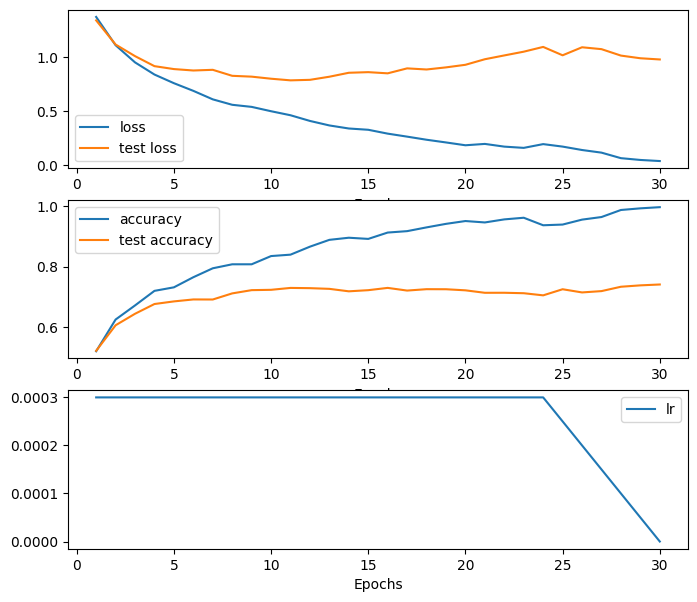

In [2]:
# Train
print("Number of steps per epoch:", len(train_data))
print(f"Number of steps total: {len(train_data) * NUM_EPOCHS}")
print("Training...")

# Initialize
start = time()
subrng, rng = jax.random.split(rng)
state = init_train_state(subrng)

# Train
state, (train_metrics, test_metrics) = train.train(
    state, train_data, test_data, num_epochs=NUM_EPOCHS)
end = time()
print(f"Time elapsed: {end - start:.2f}s")
print(f"Final test loss: {test_metrics.loss[-1]:.3f}")
print(f"Final test accuracy: {test_metrics.accuracy[-1]:.3f}")

# Plot
fig, axs = plt.subplots(3, 1, figsize=(8, 7))
epochs = jnp.arange(len(train_metrics)) + 1
axs[0].plot(epochs, train_metrics.loss, label="loss")
axs[0].plot(epochs, test_metrics.loss, label="test loss")

axs[1].plot(epochs, train_metrics.accuracy, label="accuracy")
axs[1].plot(epochs, test_metrics.accuracy, label="test accuracy")

axs[2].plot(epochs, train_metrics.lr, label="lr")

for ax in axs:
    ax.legend()
    ax.set_xlabel(f"Epochs")